In [1]:
cd /content

/content


In [2]:
! git clone https://github.com/shlvd/cs231n_stanford_2019.git

Cloning into 'cs231n_stanford_2019'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 497 (delta 17), reused 0 (delta 0), pack-reused 451
Receiving objects: 100% (497/497), 13.39 MiB | 17.53 MiB/s, done.
Resolving deltas: 100% (187/187), done.


In [3]:
%cd cs231n_stanford_2019/assignment3

/content/cs231n_stanford_2019/assignment3


In [0]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import PIL

import numpy as np

from imageio import imread
from collections import namedtuple
import matplotlib.pyplot as plt

from cs231n.image_utils import SQUEEZENET_MEAN, SQUEEZENET_STD
%matplotlib inline

In [6]:
%cd cs231n/datasets/
#%cd assignment3/cs231n/datasets/
!ls

/content/cs231n_stanford_2019/assignment3/cs231n/datasets
get_assignment3_data.sh  get_imagenet_val.sh
get_coco_captioning.sh	 get_squeezenet_tf.sh


In [0]:
!wget "http://cs231n.stanford.edu/coco_captioning.zip"
!unzip coco_captioning.zip
!rm coco_captioning.zip

--2020-01-09 08:17:35--  http://cs231n.stanford.edu/coco_captioning.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1035210391 (987M) [application/zip]
Saving to: ‘coco_captioning.zip’

coco_captioning.zip 100%[===================>] 987.25M  3.04MB/s    in 4m 12s  

2020-01-09 08:21:47 (3.92 MB/s) - ‘coco_captioning.zip’ saved [1035210391/1035210391]

Archive:  coco_captioning.zip
   creating: coco_captioning/
  inflating: coco_captioning/coco2014_captions.h5  
  inflating: coco_captioning/coco2014_vocab.json  
  inflating: coco_captioning/train2014_images.txt  
  inflating: coco_captioning/train2014_urls.txt  
  inflating: coco_captioning/train2014_vgg16_fc7.h5  
  inflating: coco_captioning/train2014_vgg16_fc7_pca.h5  
  inflating: coco_captioning/val2014_images.txt  
  inflating: coco_captioning/val2014_urls.txt  
  inf

In [8]:
!wget "http://cs231n.stanford.edu/squeezenet_tf2.zip"
!unzip squeezenet_tf2.zip
!rm squeezenet_tf2.zip

--2020-01-10 08:00:27--  http://cs231n.stanford.edu/squeezenet_tf2.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4592284 (4.4M) [application/zip]
Saving to: ‘squeezenet_tf2.zip’

squeezenet_tf2.zip  100%[===================>]   4.38M  11.8MB/s    in 0.4s    

2020-01-10 08:00:28 (11.8 MB/s) - ‘squeezenet_tf2.zip’ saved [4592284/4592284]

Archive:  squeezenet_tf2.zip
  inflating: squeezenet.ckpt.data-00000-of-00001  
  inflating: squeezenet.ckpt.index   


In [9]:
!wget http://cs231n.stanford.edu/imagenet_val_25.npz

--2020-01-10 08:00:33--  http://cs231n.stanford.edu/imagenet_val_25.npz
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [text/plain]
Saving to: ‘imagenet_val_25.npz’

imagenet_val_25.npz 100%[===================>]   3.76M  10.4MB/s    in 0.4s    

2020-01-10 08:00:33 (10.4 MB/s) - ‘imagenet_val_25.npz’ saved [3940548/3940548]



In [10]:
%cd ../../

/content/cs231n_stanford_2019/assignment3


In [0]:
def preprocess(img, size=512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1.0 / s for s in SQUEEZENET_STD.tolist()]),
        T.Normalize(mean=[-m for m in SQUEEZENET_MEAN.tolist()], std=[1, 1, 1]),
        T.Lambda(rescale),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def features_from_img(imgpath, imgsize):
    img = preprocess(PIL.Image.open(imgpath), size=imgsize)
    img_var = img.type(dtype)
    return extract_features(img_var, cnn), img_var

# Older versions of scipy.misc.imresize yield different results
# from newer versions, so we check to make sure scipy is up to date.
def check_scipy():
    import scipy
    vnum = int(scipy.__version__.split('.')[1])
    major_vnum = int(scipy.__version__.split('.')[0])
    
    assert vnum >= 16 or major_vnum >= 1, "You must install SciPy >= 0.16.0 to complete this notebook."

check_scipy()

answers = dict(np.load('style-transfer-checks.npz'))

In [0]:
dtype = torch.FloatTensor
# Uncomment out the following line if you're on a machine with a GPU set up for PyTorch!
#dtype = torch.cuda.FloatTensor 

In [0]:
# Load the pre-trained SqueezeNet model.
cnn = torchvision.models.squeezenet1_1(pretrained=True).features
cnn.type(dtype)

# We don't want to train the model any further, so we don't want PyTorch to waste computation 
# computing gradients on parameters we're never going to update.
for param in cnn.parameters():
    param.requires_grad = False

# We provide this helper code which takes an image, a model (cnn), and returns a list of
# feature maps, one per layer.
def extract_features(x, cnn):
    """
    Use the CNN to extract features from the input image x.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) holding a minibatch of images that
      will be fed to the CNN.
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of feature for the input images x extracted using the cnn model.
      features[i] is a PyTorch Tensor of shape (N, C_i, H_i, W_i); recall that features
      from different layers of the network may have different numbers of channels (C_i) and
      spatial dimensions (H_i, W_i).
    """
    features = []
    prev_feat = x
    for i, module in enumerate(cnn._modules.values()):
        next_feat = module(prev_feat)
        features.append(next_feat)
        prev_feat = next_feat
    return features

#please disregard warnings about initialization

In [0]:
def content_loss(content_weight, content_current, content_original):
    """
    Compute the content loss for style transfer.
    
    Inputs:
    - content_weight: Scalar giving the weighting for the content loss.
    - content_current: features of the current image; this is a PyTorch Tensor of shape
      (1, C_l, H_l, W_l).
    - content_target: features of the content image, Tensor with shape (1, C_l, H_l, W_l).
    
    Returns:
    - scalar content loss
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    _, C_l, H_l, W_l = content_current.size()
    
    F_l = content_current.squeeze().view(C_l, -1)
    P_l = content_original.squeeze().view(C_l, -1)
    
    return content_weight * torch.dist(F_l, P_l) ** 2 
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [32]:
def content_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    content_layer = 3
    content_weight = 6e-2
    
    c_feats, content_img_var = features_from_img(content_image, image_size)
    
    bad_img = torch.zeros(*content_img_var.data.size()).type(dtype)
    feats = extract_features(bad_img, cnn)
    
    student_output = content_loss(content_weight, c_feats[content_layer], feats[content_layer]).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.9f}'.format(error))

content_loss_test(answers['cl_out'])

Maximum error is 0.000000060


In [0]:
def gram_matrix(features, normalize=True):
    """
    Compute the Gram matrix from features.
    
    Inputs:
    - features: PyTorch Tensor of shape (N, C, H, W) giving features for
      a batch of N images.
    - normalize: optional, whether to normalize the Gram matrix
        If True, divide the Gram matrix by the number of neurons (H * W * C)
    
    Returns:
    - gram: PyTorch Tensor of shape (N, C, C) giving the
      (optionally normalized) Gram matrices for the N input images.
    """
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N, C, H, W = features.size()
    
    features = features.view(N, C, -1)

    gram = features.matmul(features.permute(0, 2, 1))
        
    if normalize:
        gram /= (H * W * C)
    
    return gram
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [35]:
def gram_matrix_test(correct):
    style_image = 'styles/starry_night.jpg'
    style_size = 192
    feats, _ = features_from_img(style_image, style_size)
    student_output = gram_matrix(feats[5].clone()).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Maximum error is {:.9f}'.format(error))
    
gram_matrix_test(answers['gm_out'])

Maximum error is 0.000000335


In [0]:
# Now put it together in the style_loss function...
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function.
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - style_loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    # Hint: you can do this with one for loop over the style layers, and should
    # not be very much code (~5 lines). You will need to use your gram_matrix function.
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    loss = 0
    
    for i in range(len(style_layers)):
        loss += style_weights[i] * torch.sum((gram_matrix(feats[style_layers[i]]) - style_targets[i]) ** 2)
        
    return loss

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [37]:
def style_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    style_image = 'styles/starry_night.jpg'
    image_size =  192
    style_size = 192
    style_layers = [1, 4, 6, 7]
    style_weights = [300000, 1000, 15, 3]
    
    c_feats, _ = features_from_img(content_image, image_size)    
    feats, _ = features_from_img(style_image, style_size)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))
    
    student_output = style_loss(c_feats, style_layers, style_targets, style_weights).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.9f}'.format(error))

    
style_loss_test(answers['sl_out'])

Error is 0.000015357


In [0]:
def tv_loss(img, tv_weight):
    """
    Compute total variation loss.
    
    Inputs:
    - img: PyTorch Variable of shape (1, 3, H, W) holding an input image.
    - tv_weight: Scalar giving the weight w_t to use for the TV loss.
    
    Returns:
    - loss: PyTorch Variable holding a scalar giving the total variation loss
      for img weighted by tv_weight.
    """
    # Your implementation should be vectorized and not require any loops!
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    H_var = torch.sum((img[:, :, 1:, :] - img[:, :, :-1, :]) ** 2)
    W_var = torch.sum((img[:, :, :, 1:] - img[:, :, :, :-1]) ** 2)
    
    return tv_weight * (H_var + W_var)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [39]:
def tv_loss_test(correct):
    content_image = 'styles/tubingen.jpg'
    image_size =  192
    tv_weight = 2e-2

    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    
    student_output = tv_loss(content_img, tv_weight).cpu().data.numpy()
    error = rel_error(correct, student_output)
    print('Error is {:.9f}'.format(error))
    
tv_loss_test(answers['tv_out'])

Error is 0.000003972


In [0]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight,
                   style_layers, style_weights, tv_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - tv_weight: weight of total variation regularization term
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = preprocess(PIL.Image.open(content_image), size=image_size).type(dtype)
    feats = extract_features(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = preprocess(PIL.Image.open(style_image), size=style_size).type(dtype)
    feats = extract_features(style_img, cnn)
    style_targets = []
    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).type(dtype)
    else:
        img = content_img.clone().type(dtype)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    f, axarr = plt.subplots(1,2)
    axarr[0].axis('off')
    axarr[1].axis('off')
    axarr[0].set_title('Content Source Img.')
    axarr[1].set_title('Style Source Img.')
    axarr[0].imshow(deprocess(content_img.cpu()))
    axarr[1].imshow(deprocess(style_img.cpu()))
    plt.show()
    plt.figure()
    
    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = extract_features(img, cnn)
        
        # Compute loss
        c_loss = content_loss(content_weight, feats[content_layer], content_target)
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)
        t_loss = tv_loss(img, tv_weight) 
        loss = c_loss + s_loss + t_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.axis('off')
            plt.imshow(deprocess(img.data.cpu()))
            plt.show()
    print('Iteration {}'.format(t))
    plt.axis('off')
    plt.imshow(deprocess(img.data.cpu()))
    plt.show()

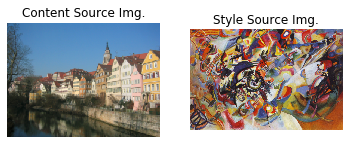

Iteration 0


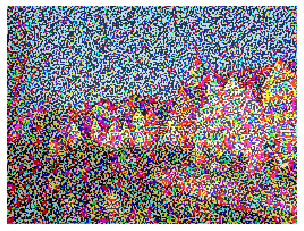

Iteration 100


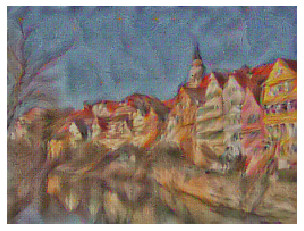

Iteration 199


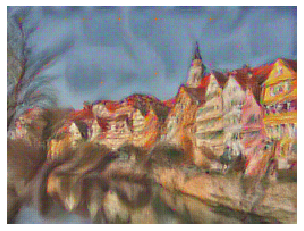

In [43]:
# Composition VII + Tubingen
params1 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/composition_vii.jpg',
    'image_size' : 192,
    'style_size' : 512,
    'content_layer' : 3,
    'content_weight' : 5e-2, 
    'style_layers' : (1, 4, 6, 7),
    'style_weights' : (20000, 500, 12, 1),
    'tv_weight' : 5e-2
}

style_transfer(**params1)

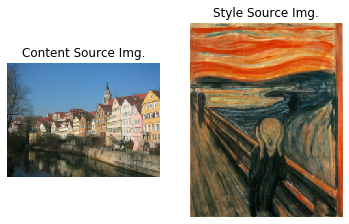

Iteration 0


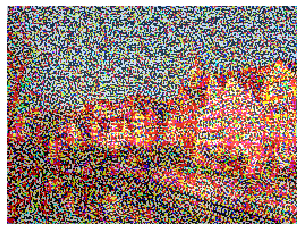

Iteration 100


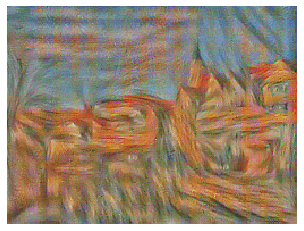

Iteration 199


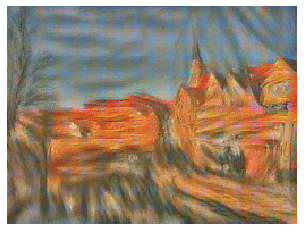

In [44]:
# Scream + Tubingen
params2 = {
    'content_image':'styles/tubingen.jpg',
    'style_image':'styles/the_scream.jpg',
    'image_size':192,
    'style_size':224,
    'content_layer':3,
    'content_weight':3e-2,
    'style_layers':[1, 4, 6, 7],
    'style_weights':[200000, 800, 12, 1],
    'tv_weight':2e-2
}

style_transfer(**params2)

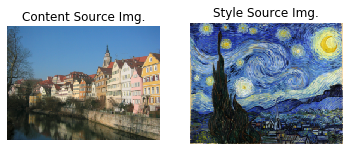

Iteration 0


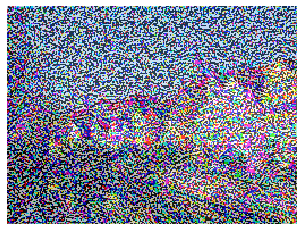

Iteration 100


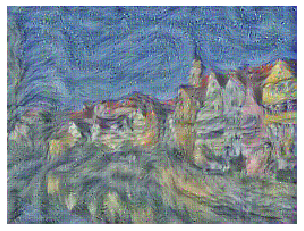

Iteration 199


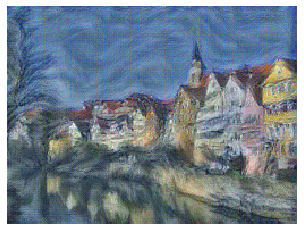

In [45]:
# Starry Night + Tubingen
params3 = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [300000, 1000, 15, 3],
    'tv_weight' : 2e-2
}

style_transfer(**params3)

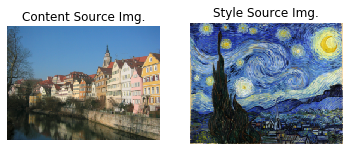

Iteration 0


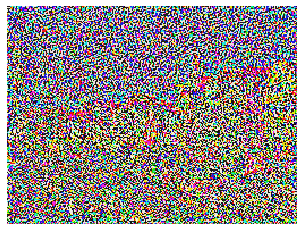

Iteration 100


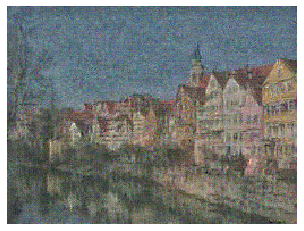

Iteration 199


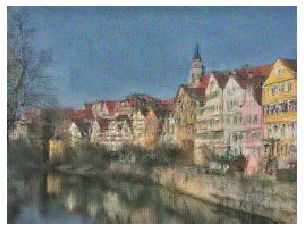

In [46]:
# Feature Inversion -- Starry Night + Tubingen
params_inv = {
    'content_image' : 'styles/tubingen.jpg',
    'style_image' : 'styles/starry_night.jpg',
    'image_size' : 192,
    'style_size' : 192,
    'content_layer' : 3,
    'content_weight' : 6e-2,
    'style_layers' : [1, 4, 6, 7],
    'style_weights' : [0, 0, 0, 0], # we discard any contributions from style to the loss
    'tv_weight' : 2e-2,
    'init_random': True # we want to initialize our image to be random
}

style_transfer(**params_inv)